In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang", "simtrial","tidyverse")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Rfiles/3m_comparison.R')
source('/home/r27user6/RMST_Code/Rfiles/Function.R')
source('/home/r27user6/RMST_Code/Rfiles/get_opt_des.R')

# NPH Early Difference

## We added a Interim Period Under Non Proportional Hazard
####  $\textcolor{yellow}{H_0 : \lambda_0 = \lambda_1 = 1.2}$    
####  $\textcolor{yellow}{H_1 : \lambda_0 = 1.2,\ \lambda_1 = Piecewise\ Exponential}$
#### HR1 is the hazard ratio before the change_time and HR2 is after
#### $HR1 = 0.67, HR2 = 1$

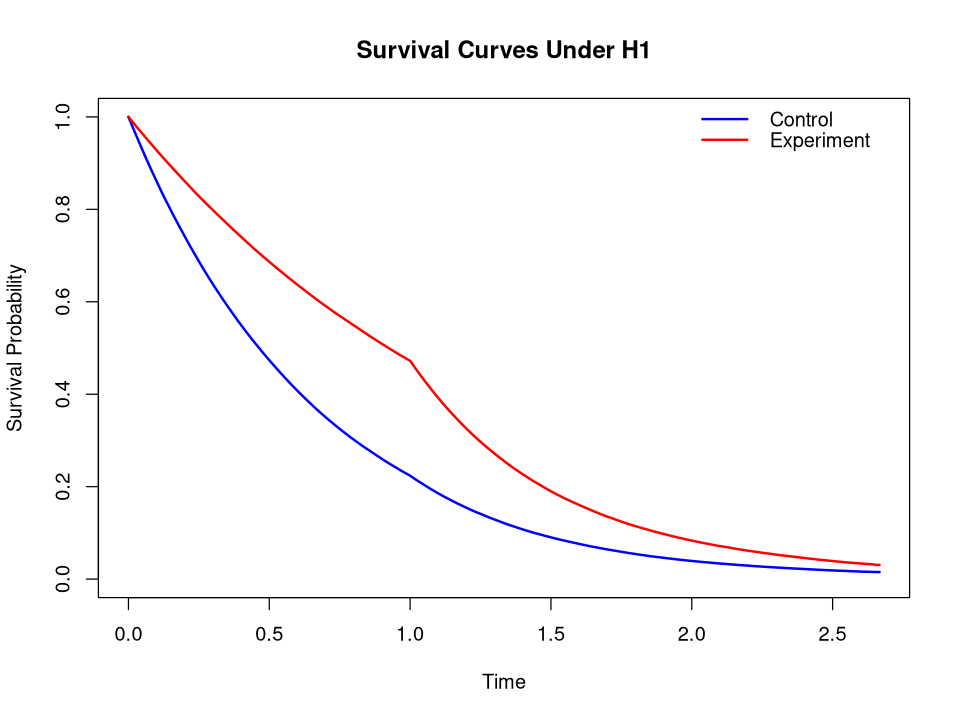

In [10]:
lambda_H0 <- 1.5
HR1 <- 0.5
HR2 <- 1
sim_size <- 10000 
N <- 100
n <- ceiling(N / 2) 
r <- 60  # patient recruit rate
acc_time <- N / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.6  # The time point between HR1 and HR2
set.seed(2024)

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0,
                         dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                         dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)                         
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                          dist = 'pcw_exp', cen_time = cen_time,HR1 = HR1, HR2 = HR2, 
                          change_time = change_time, arm = 1, interim = interim)

pre_data <- rbind(data_C[ , c(4,5,1)], data_E_H1[ , c(4,5,1)])
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])

options(repr.plot.width = 8, repr.plot.height = 6)
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves Under H1")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")


## 1.  Different Hazard Ratio (HR1)
#### $H0: \lambda_E = \lambda_C = 1.2$ is fixed.
#### $H1: \lambda_C = 1.2,\ \lambda_{E1} = 1.2*HR1$, where $\lambda_{E1}$ is the hazard of period 1. 
#### Fix HR2, Change HR1

In [3]:
lambda_H0 <- 1.2
HR2 <- 1
sim_size <- 5000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
change_time <- acc_time * 0.6  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_hr1_ED <- foreach(HR1 = seq(0.5, 0.9, by = 0.05), .combine = rbind) %dopar%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(HR1, result$alpha, result$power, result$PET0, result$PET1)      
    }


Warning message in fun(result.1, result.2, result.3, result.4, result.5, result.6, :
“number of columns of result is not a multiple of vector length (arg 1)”


In [5]:
diff_hr1_ED

result.1,0.50,0.0496,0.0492,0.0486,0.9720,0.9800,0.7806,0.4768,0.4578,0.9496,⋯,0.9720,0.9800,0.7806,0.4768,0.4578,0.9496,0.0062,0.0056,0.2194,0.5000
result.2,0.55,0.0498,0.0494,0.0492,0.9342,0.9440,0.6700,0.4634,0.4600,0.9498,⋯,0.9342,0.9440,0.6700,0.4634,0.4600,0.9498,0.0132,0.0150,0.3300,0.5500
result.3,0.60,0.0498,0.0486,0.0498,0.0494,0.0496,0.0492,0.8604,0.8908,0.5876,⋯,0.5576,0.0232,0.0104,0.4124,0.1534,0.0582,0.0152,0.6000,0.0498,0.0486
result.4,0.65,0.0496,0.0498,0.0478,0.7648,0.7938,0.8170,0.3922,0.3666,0.3686,⋯,0.7648,0.7938,0.8170,0.3922,0.3666,0.3686,0.0328,0.0304,0.0216,0.6500
result.5,0.70,0.0496,0.0496,0.0492,0.6246,0.6568,0.6680,0.4196,0.3560,0.3306,⋯,0.6246,0.6568,0.6680,0.4196,0.3560,0.3306,0.0624,0.0470,0.0368,0.7000
result.6,0.75,0.0498,0.0498,0.0498,0.4876,0.5128,0.5274,0.3286,0.3000,0.3492,⋯,0.4876,0.5128,0.5274,0.3286,0.3000,0.3492,0.0632,0.0588,0.0714,0.7500
result.7,0.80,0.0496,0.0498,0.0486,0.3626,0.3918,0.4128,0.6018,0.3000,0.3052,⋯,0.3626,0.3918,0.4128,0.6018,0.3000,0.3052,0.2850,0.0954,0.0962,0.8000
result.8,0.85,0.0498,0.0498,0.0498,0.2182,0.2314,0.2914,0.7694,0.7540,0.3102,⋯,0.2182,0.2314,0.2914,0.7694,0.7540,0.3102,0.5508,0.5244,0.1384,0.8500
result.9,0.90,0.0000,0.0000,0.0494,0.0498,0.0498,0.0498,0.0498,0.0498,0.0498,⋯,0.3054,0.2704,0.2522,0.2366,0.2056,0.1918,0.1890,0.1876,0.1896,0.1910


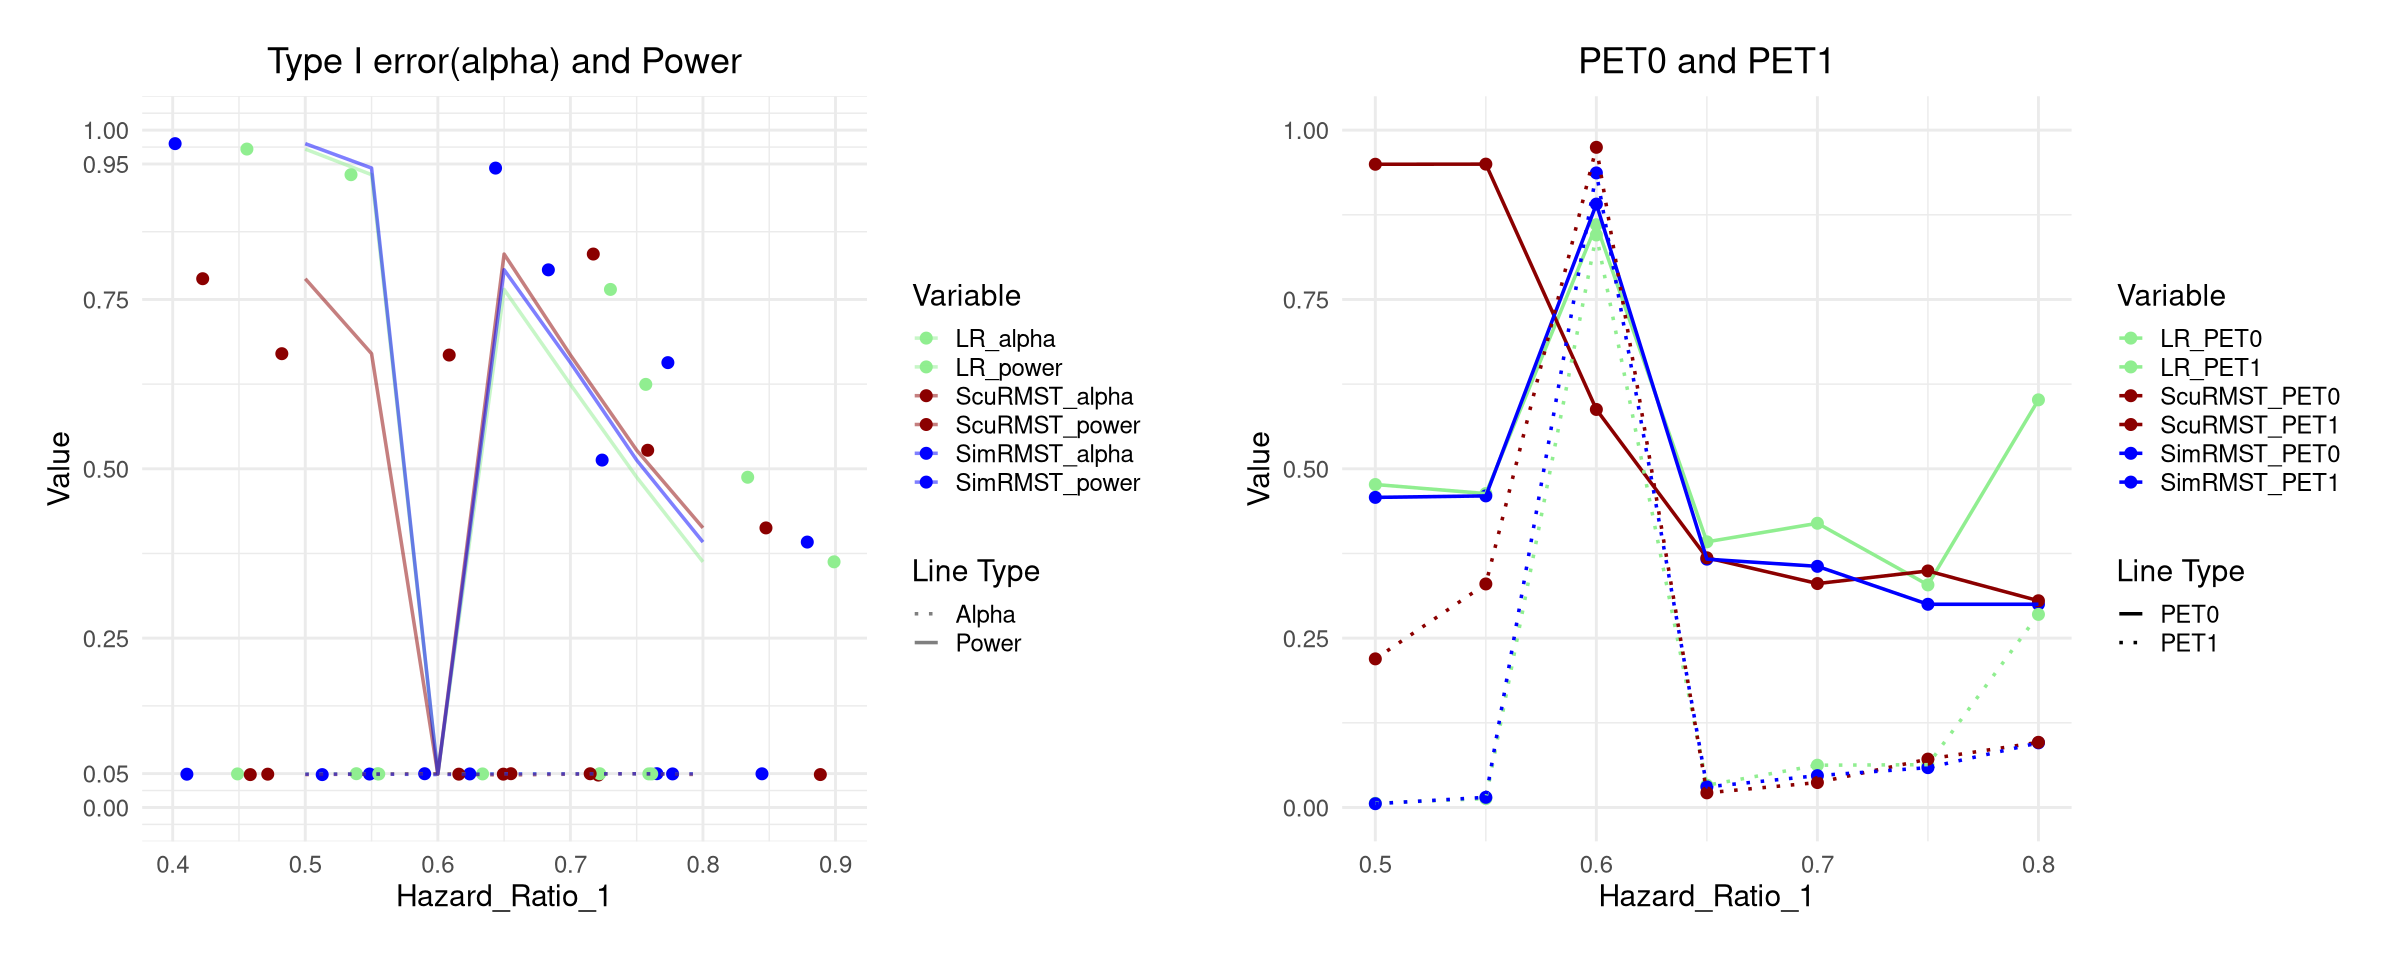

In [4]:
save(diff_hr1_ED, file = '/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
#load('/home/r27user6/RMST_Code/RData/diff_hr1_ED.RData')
# self-define function for drawing plots
p1 <- compare_line_plot(data = diff_hr1_ED[1:7,], var_name = 'Hazard_Ratio_1')
p1


## 2. Different interim period

In [22]:
set.seed(2024)
lambda_H0 <- 1.5
HR1 <- 0.5
HR2 <- 1
N <- 150
sim_size <- 6000 
n <- ceiling(N / 2) 
r <- 100  # patient recruit rate
acc_time <- N / r
cen_time <- 1
change_time <- 0.6 # The time point between HR1 and HR2
alpha <- 0.05

diff_interim_ED <- c()
for (int_sam in seq(0.4, 0.8, by = 0.05))
    {
        interim <- int_sam * acc_time
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', tau = 2.5,
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        diff_interim_ED <- rbind(diff_interim_ED,
                            c(interim*r, result$alpha, result$power, result$PET0, result$PET1))     
    }
save(diff_interim_ED, file = '/home/r27user6/RMST_Code/RData/diff_interim_ED.RData')

In [23]:
lambda_H0 <- 1.5
HR1 <- 1
HR2 <- 0.5
sim_size <- 6000
N <- 150
r <- 100
n <- ceiling(N / 2) 
acc_time <- N/r
cen_time <- 1
change_time <- 0.6  # The time point between HR1 and HR2
alpha <- 0.05

diff_interim_LD <- c()
for(int_sam in seq(0.4, 0.8, by = 0.05))
    {
        interim <- int_sam * acc_time
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', tau = 2.5,
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        diff_interim_LD <- rbind(diff_interim_LD,
                            c(int_sam * N, result$alpha, result$power, result$PET0, result$PET1))      
    }
save(diff_interim_LD, file = '/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')


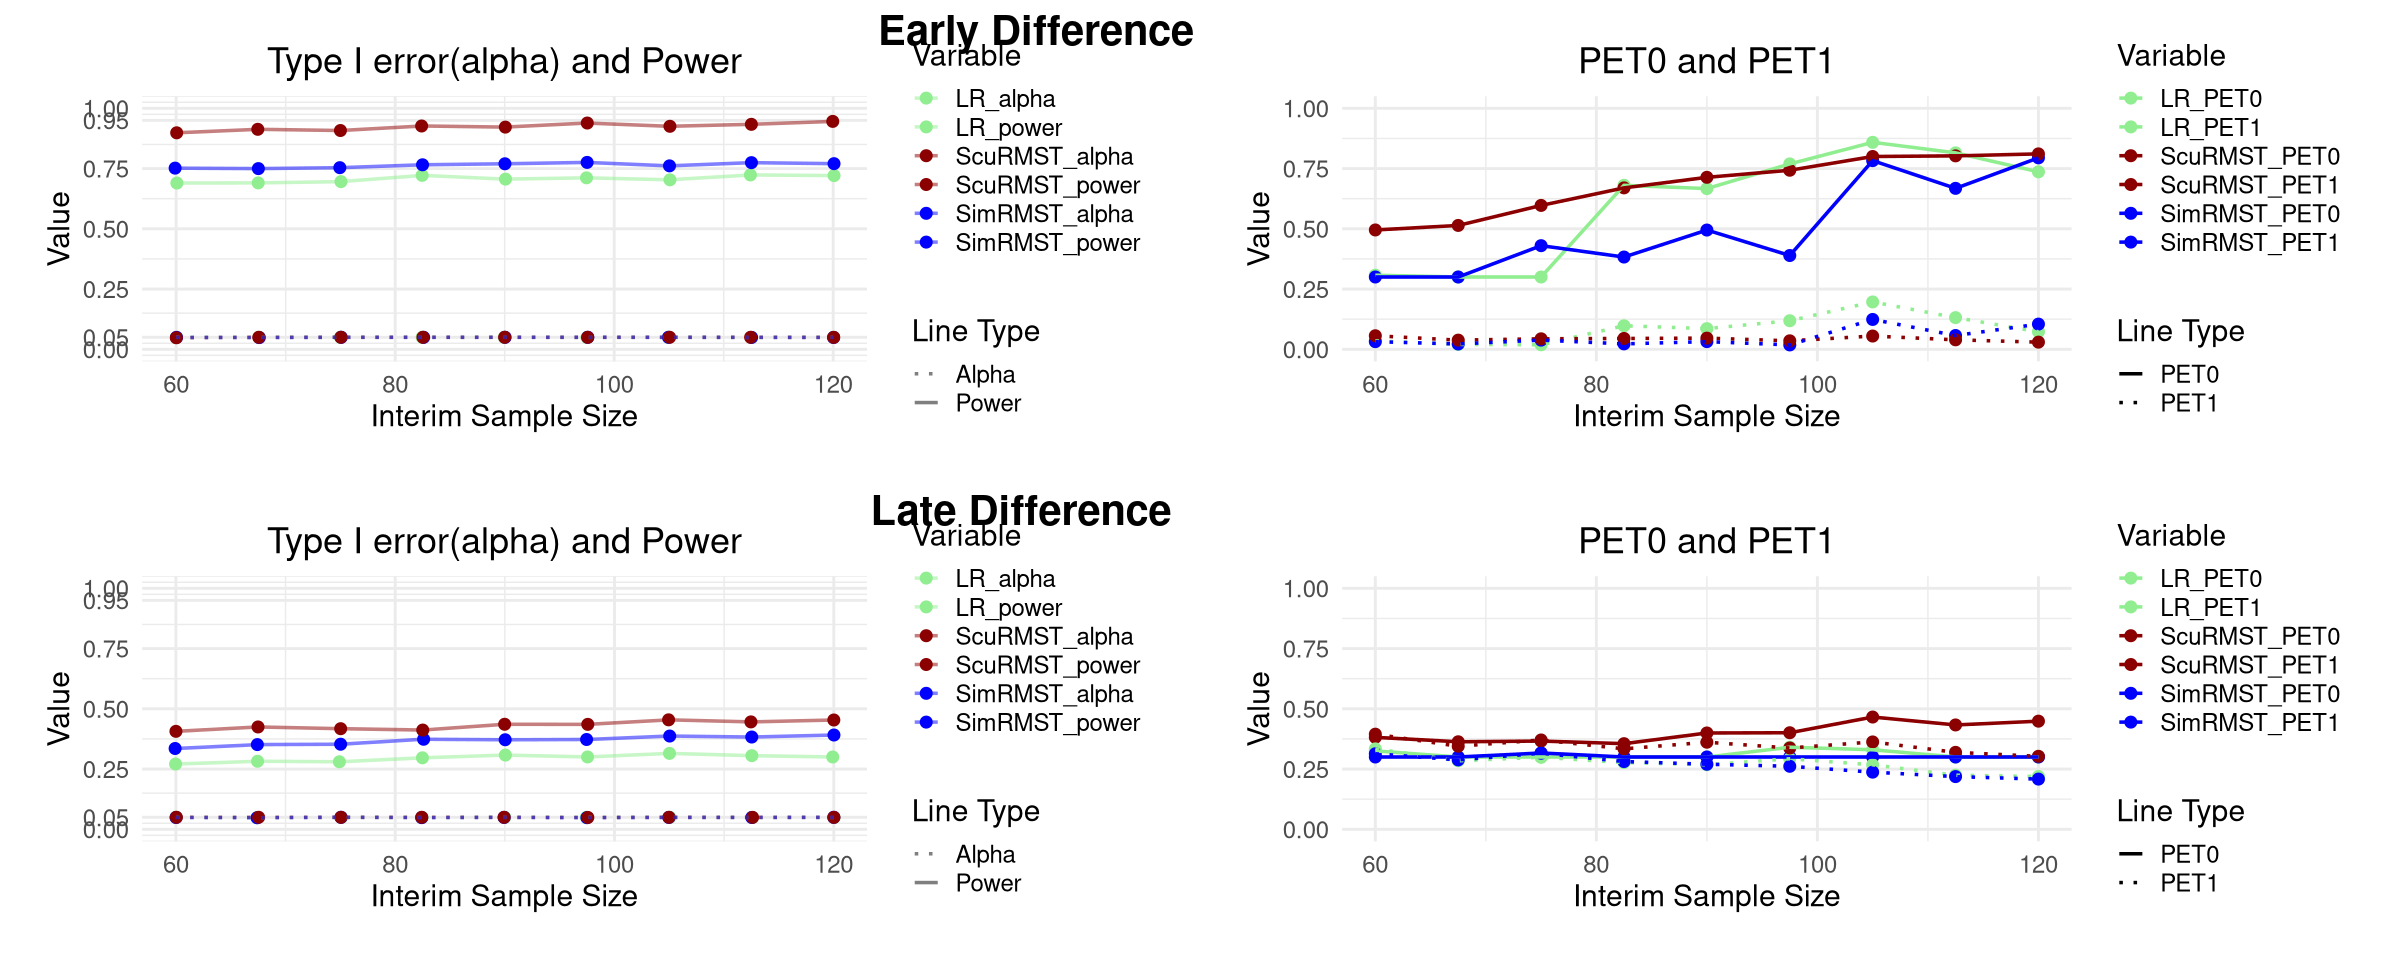

In [21]:
load('/home/r27user6/RMST_Code/RData/diff_interim_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim_LD.RData')
p2_late_diff <- compare_line_plot(data = diff_interim_LD, var_name = 'Interim Sample Size')
p2_early_diff <- compare_line_plot(data = diff_interim_ED, var_name = 'Interim Sample Size')
p <- plot_grid(p2_early_diff, p2_late_diff, labels = c("Early Difference", "Late Difference"), 
            label_x = c(0.3, 0.3), label_size = 25, ncol = 1)
p
ggsave("/home/r27user6/RMST_Code/figures/Comparison/early_late_diff_itrm.jpg", 
        plot = p,width = 20, height = 15, dpi = 300)


------
## 3. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [7]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
cen_time <- 1
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_rec_rate_ED <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %dopar%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(r, result$alpha, result$power, result$PET0, result$PET1)  
    }

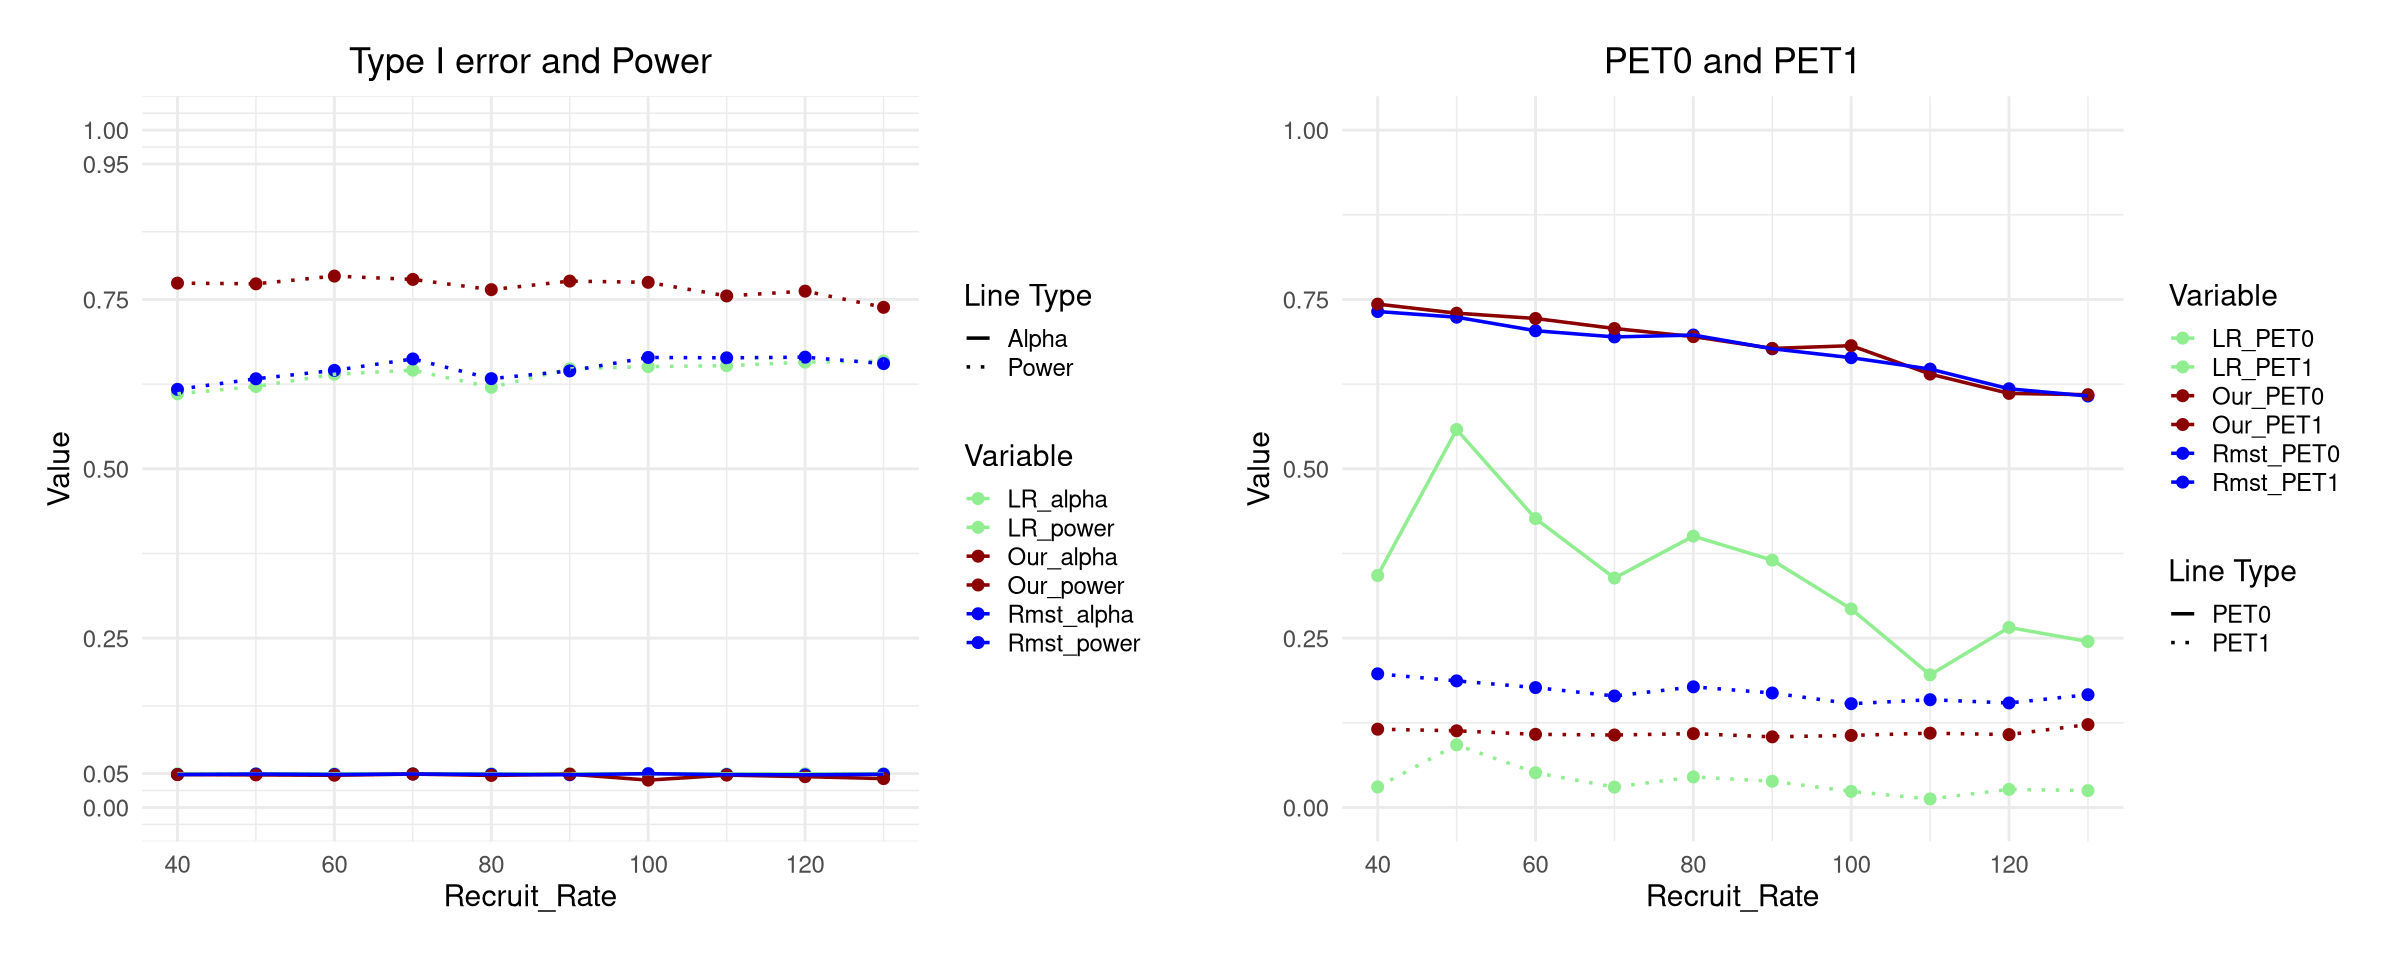

In [16]:
save(diff_rec_rate_ED, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate_ED.RData')

p3 <- compare_line_plot(data = diff_rec_rate_ED, var_name = 'Recruit_Rate')
p3

------
## 4. Different Changing Point
#### The time point of HR1 to HR2

In [9]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
set.seed(2024)

alpha <- 0.05

diff_ct_ED <- foreach(ct_rate = seq(0.2, 0.8, by = 0.06), .combine = rbind) %dopar%
    {
        change_time <- acc_time * ct_rate
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(change_time, result$alpha, result$power, result$PET0, result$PET1)  
    }

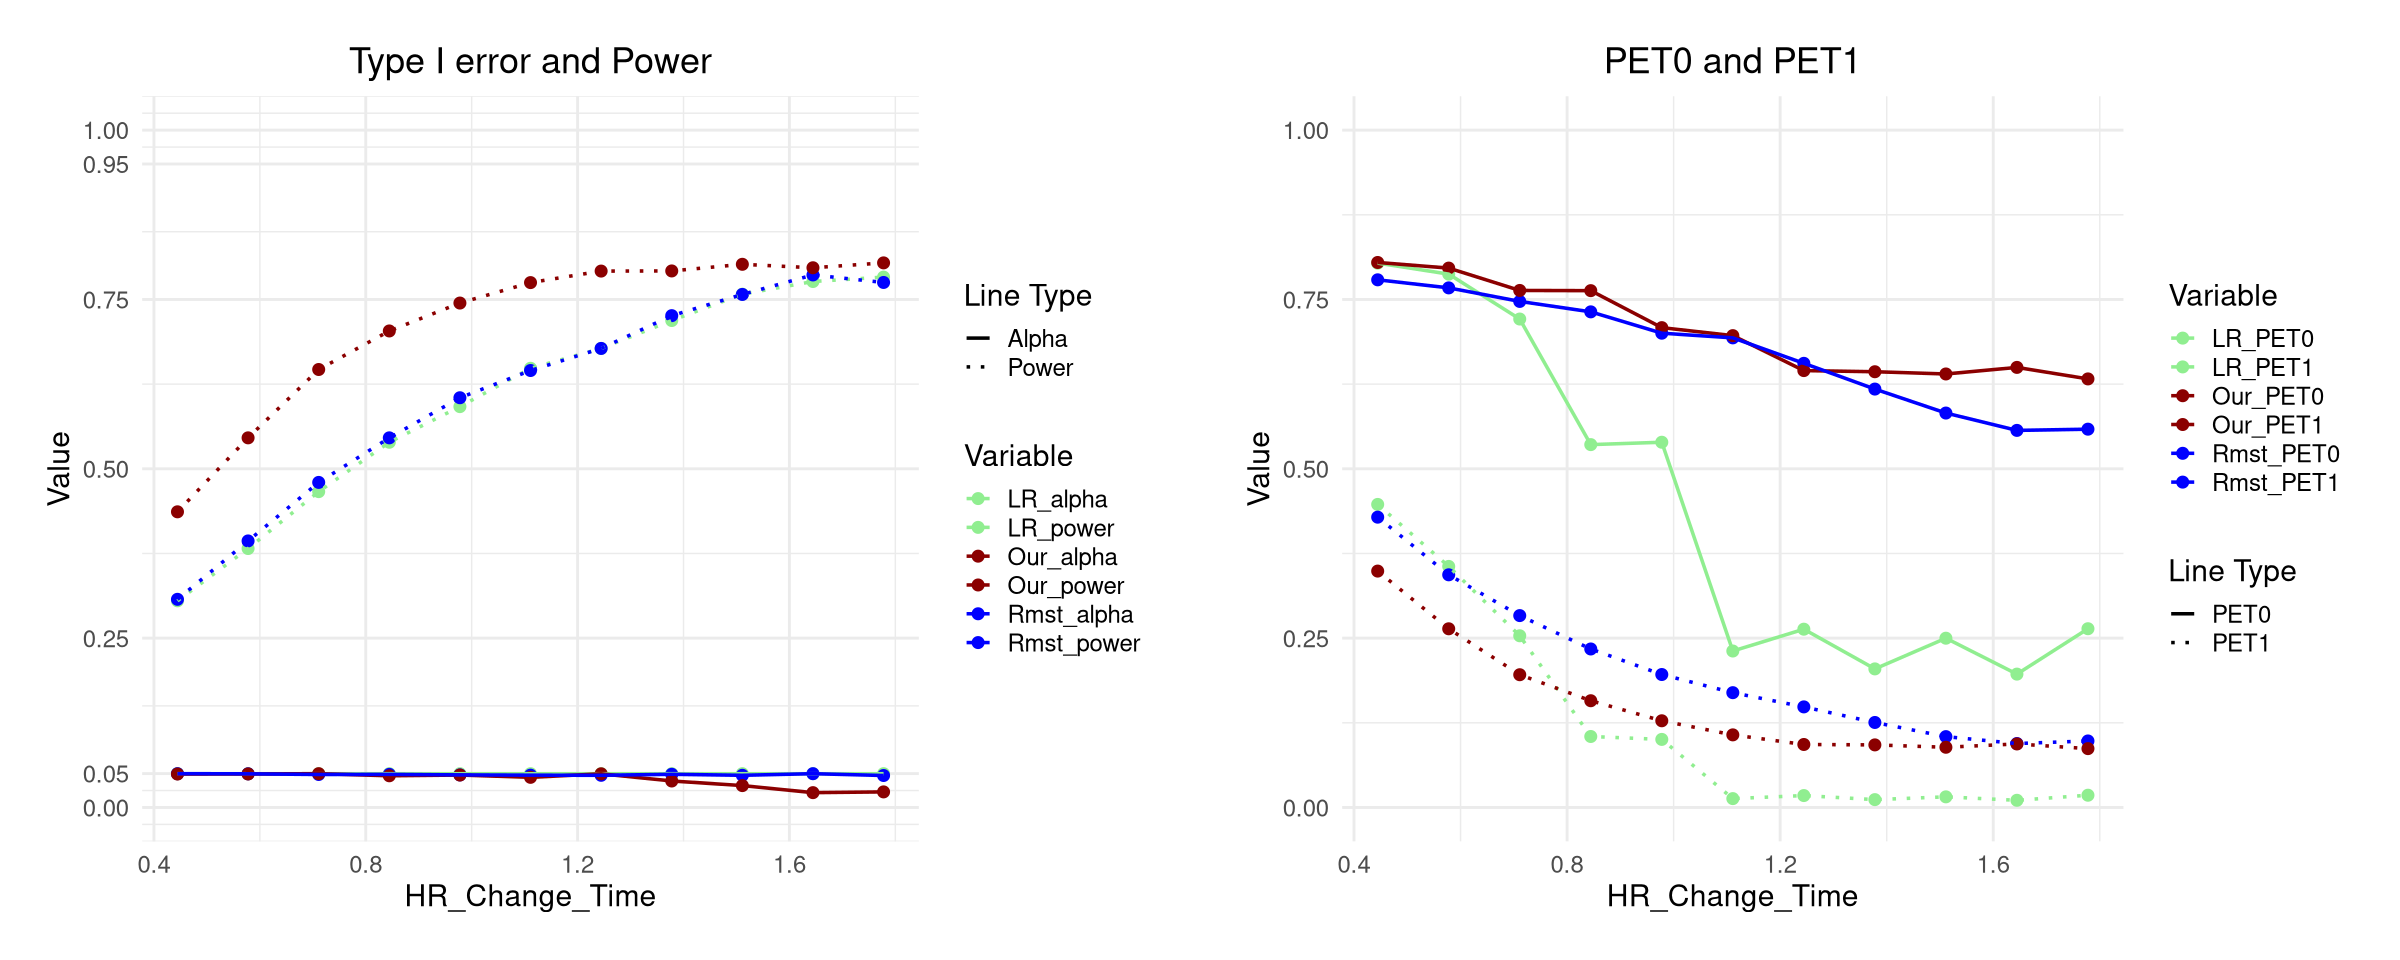

In [5]:
#save(diff_ct_ED, file = '/home/r27user6/RMST_Code/RData/diff_ct_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_ct_ED.RData')

p4 <- compare_line_plot(data = diff_ct_ED, var_name = 'HR_Change_Time')
p4

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [11]:
lambda_H0 <- 1.2
HR1 <- 0.67
HR2 <- 1
sim_size <- 10000 
n <- ceiling(200 / 2) 
r <- 90    # patient recruit rate
acc_time <- 200 / r
interim <- 120 / r
change_time <- acc_time * 0.5  # The time point between HR1 and HR2
set.seed(2024)

alpha <- 0.05

diff_cen_ED <- foreach(cen_time = seq(0.6, 1.5, by = 0.1), .combine = rbind) %dopar%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, H1_type = 'NPH', 
                HR1 = HR1, HR2 = HR2, change_time = change_time, alpha = alpha)        
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)        
    }

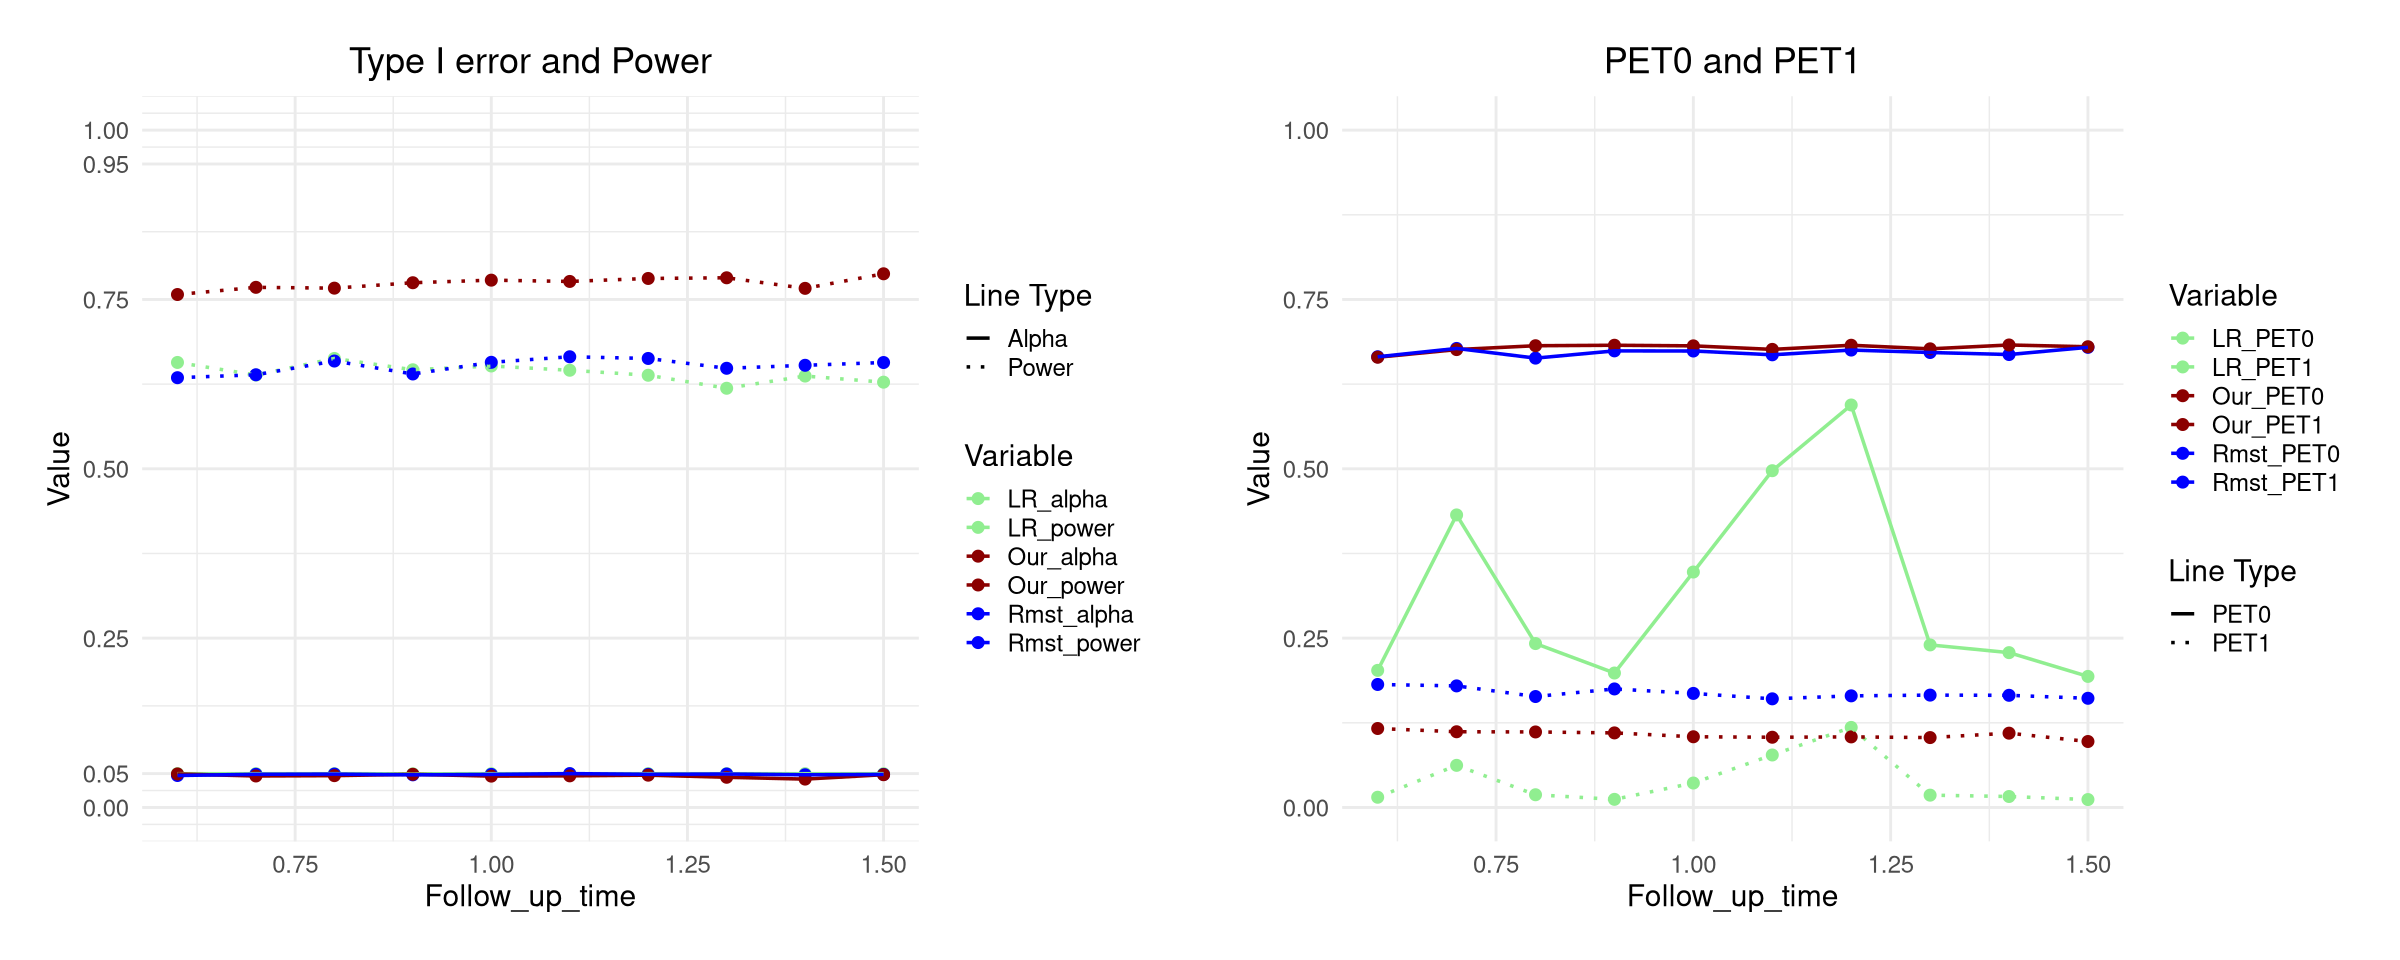

In [8]:
#save(diff_cen_ED, file = '/home/r27user6/RMST_Code/RData/diff_cen_ED.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen_ED.RData')

p5 <- compare_line_plot(data = diff_cen_ED, var_name = 'Follow_up_time')
p5

-----
# Optimal design

### Set a minimal $N_0$ (Single stage RMST sample size can be used as reference)
### For every $N_i > N_0$ find the $min E_{N_i}(n_j)$, where $n_j$ is the interim sample size
### Then find the $min E_{N_i}$ for all $N_i$
### Use the same setting as above
#### 1. Calculate the single stage RMST sample size under ($\alpha = 0.05, power = 0.8$)

In [ ]:
lambda_H0 <- 1.5
HR1 <- 0.5
HR2 <- 1
N <- 200
sim_size <- 5000 
n <- ceiling(N / 2) 
r <- 90  # patient recruit rate
acc_time <- N / r
cen_time <- 1
change_time <- 0.6 # The time point between HR1 and HR2
interim <- 0.7
alpha <- 0.05

data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                           cen_time = cen_time,arm = 0, interim = interim) 
data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, 
                            dist = 'pcw_exp', cen_time = cen_time, HR1 = HR1, HR2 = HR2, 
                            change_time = change_time, arm = 1, interim = interim)
# power of one sided log rank test
log_rank_1 <- log_rank_sim(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)] 
                            ,sim_size = sim_size, n = n, alpha = alpha ,sided = 'greater')
log_rank_1$rejection

# power of one sided RMST difference test
simple_rmst_1 <- RMST_sim_test(data_C = data_C[ , c(4,5,1)] , data_E = data_E_H1[ , c(4,5,1)]
                            ,sim_size = sim_size, tau = 2.5, n = n
                            ,alpha = alpha ,sided = 'greater')
simple_rmst_1$test_result$rejection

[1] 0.7924

[1] 0.8284

In [6]:
set.seed(2024)
lambda_H0 <- 1.5
HR1 <- 0.4
HR2 <- 1
sim_size <- 5000 
r <- 60  # patient recruit rate
cen_time <- 1
change_time <- 1 # The time point between HR1 and HR2

alpha <- 0.1
power <- 0.85

result_LR <- data.frame()
result_scu <- c()
result_sim <- c()

for (N in seq(from = 34, to = 54, 4))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    our_rmst <-  get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                        int_step = 2, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, tau = 1.2,
                        change_time = change_time, alpha = alpha, power = power, method = 'Complex') 
    res <- our_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- 'scu_rmst'
    result_scu <- rbind(result_scu, res)
    saveRDS(result_scu, "tem_result_scu.rds")
}

for (N in seq(from = 40, to = 56, 4))
{
    n <- ceiling(N / 2) 
    acc_time <- N/r
    sim_rmst <-  get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                        int_step = 2, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, tau = 1.2,
                        change_time = change_time, alpha = alpha, power = power, method = 'Simple')     
    res <- sim_rmst[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
    res$N <- c(N)
    res$Method <- 'sim_rmst'
    result_sim <- rbind(result_sim, res)
    saveRDS(result_sim, "tem_result_sim.rds")
 }

# for (N in seq(50, 60, by = 2))
# {
#     n <- ceiling(N / 2) 
#     acc_time <- N / r 
#     lr_opt <- get_opt_des(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#                         int_step = 2, lambda_H0 = lambda_H0, H1_type = 'NPH', HR1 = HR1, HR2 = HR2, 
#                         change_time = change_time, alpha = alpha, power = power, method = 'logrank')   
#     res <- lr_opt[, c('PET0','PET1','alpha','power','PET','EN0','EN1','EN','interim_n')]
#     res$N <- N
#     res$Method <- 'log_rank'
#     result_LR <- rbind(result_LR, res)
#     saveRDS(result_LR, "tem_result_lr.rds")
# }

# result_LR
result_sim
result_scu


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,40,sim_rmst
2,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,44,sim_rmst
5253,0.3000,0.0410,0.0994,0.8504,0.1705,42.96000,47.31120,45.13560,32,48,sim_rmst
4965,0.4084,0.0774,0.0992,0.8522,0.2429,43.34192,50.35912,46.85052,31,52,sim_rmst
4765,0.4232,0.1028,0.0982,0.8514,0.2630,44.31968,53.16272,48.74120,29,56,sim_rmst


,PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.0000,0.0000,0.0000,0.0000,0.0000,NA,NA,NA,NA,34,scu_rmst
610,0.3840,0.1246,0.0998,0.8510,0.2543,31.54880,35.90672,33.72776,22,38,scu_rmst
7,0.3830,0.1312,0.0972,0.8504,0.2571,33.88040,39.21856,36.54948,21,42,scu_rmst
2237,0.4256,0.1318,0.0990,0.8510,0.2787,36.80704,43.15312,39.98008,25,46,scu_rmst
3550,0.4086,0.1248,0.0984,0.8512,0.2667,39.37640,46.75520,43.06580,24,50,scu_rmst
2442,0.4264,0.1424,0.0998,0.8502,0.2844,41.03744,49.67104,45.35424,24,54,scu_rmst


In [28]:
#readRDS("tem_result_scu.rds")
readRDS("tem_result_lr.rds")

PET0,PET1,alpha,power,PET,EN0,EN1,EN,interim_n,N,Method
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>,<dbl>,<chr>
0,0,0,0,0,NA,NA,NA,NA,200,log_rank
0,0,0,0,0,NA,NA,NA,NA,206,log_rank
0,0,0,0,0,NA,NA,NA,NA,212,log_rank
0,0,0,0,0,NA,NA,NA,NA,218,log_rank


----